# Laminography automatic alignment
This notebook demonstrates tools to automatically align the tilt and center of rotation offset parameters for data collected in a laminography geometry, to optimise the best reconstructed volume.

Laminography is an imaging techique, similar to tomography, where projections are collected at multiple positions around a sample then used to reconstruct a 3D volume. Laminography is used on flat samples, where the typical tomography setup results in artefacts caused by un-even absorption between projections. In laminography, the rotation axis is tilted relative to the detector plane to make the absorption more equal.

The notebook laminography_artefacts.ipynb shows examples of the kind of artefacts that are solved by and caused by the laminography setup. It also shows what happens if the tilt or centre of rotation offset is not precisely known.

Here we input some parameters that the script will use:


In [1]:
file_path = '/mnt/share/ALC_laminography/folder/k11-67208_binned.nxs'
cor = 0 # pix
tilt = 35 # deg

optimise_geometry = True
cor_bounds = (-20, 20) # pixels
tilt_bounds = (30, 40) # deg
tilt_tol = 0.01 # deg
cor_tol = 0.01 # pixels

In [2]:
from scripts.geometry_corrector import GeometryCorrector
from scripts.shrink_volume import VolumeShrinker
from cil.io.utilities import HDF5_utilities
from cil.framework import AcquisitionData, AcquisitionGeometry
from cil.processors import TransmissionAbsorptionConverter, Normaliser
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.plugins.astra.processors import FBP
from cil.io import TIFFWriter

import numpy as np
from scipy.spatial.transform import Rotation as R
import os

/home/bgb37495/miniconda3/envs/lamino_small/lib/python3.12/site-packages/dxchange/__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


First we load a DIAD dataset

In [3]:
image_key = HDF5_utilities.read(filename=file_path, dset_path='entry/instrument/imaging/image_key')

unique_keys, counts = np.unique(image_key, return_counts=True)
for key, count in zip(unique_keys, counts):
    key_type = {0: "Tomography", 1: "Flat field", 2: "Dark field"}.get(key, f"Unknown ({key})")
    print(f"  {key_type} images: {count}")

data = HDF5_utilities.read(filename=file_path, dset_path='/entry/imaging/data', source_sel=(image_key == 0,))
flat = HDF5_utilities.read(filename=file_path, dset_path='/entry/imaging/data', source_sel=(image_key == 1,))
dark = HDF5_utilities.read(filename=file_path, dset_path='/entry/imaging/data', source_sel=(image_key == 2,))

angles = HDF5_utilities.read(filename=file_path, dset_path='/entry/imaging_sum/smaract_zrot_value_set')
pixel_size_x = HDF5_utilities.read(filename=file_path, dset_path='/entry/tomo_entry/instrument/detector/x_pixel_size')
pixel_size_y = HDF5_utilities.read(filename=file_path, dset_path='/entry/tomo_entry/instrument/detector/y_pixel_size')


  Tomography images: 4000
  Flat field images: 50
  Dark field images: 50


Next we describe the experimental geometry. We setup the detector and apply the tilted rotation axis and centre of rotation offset.

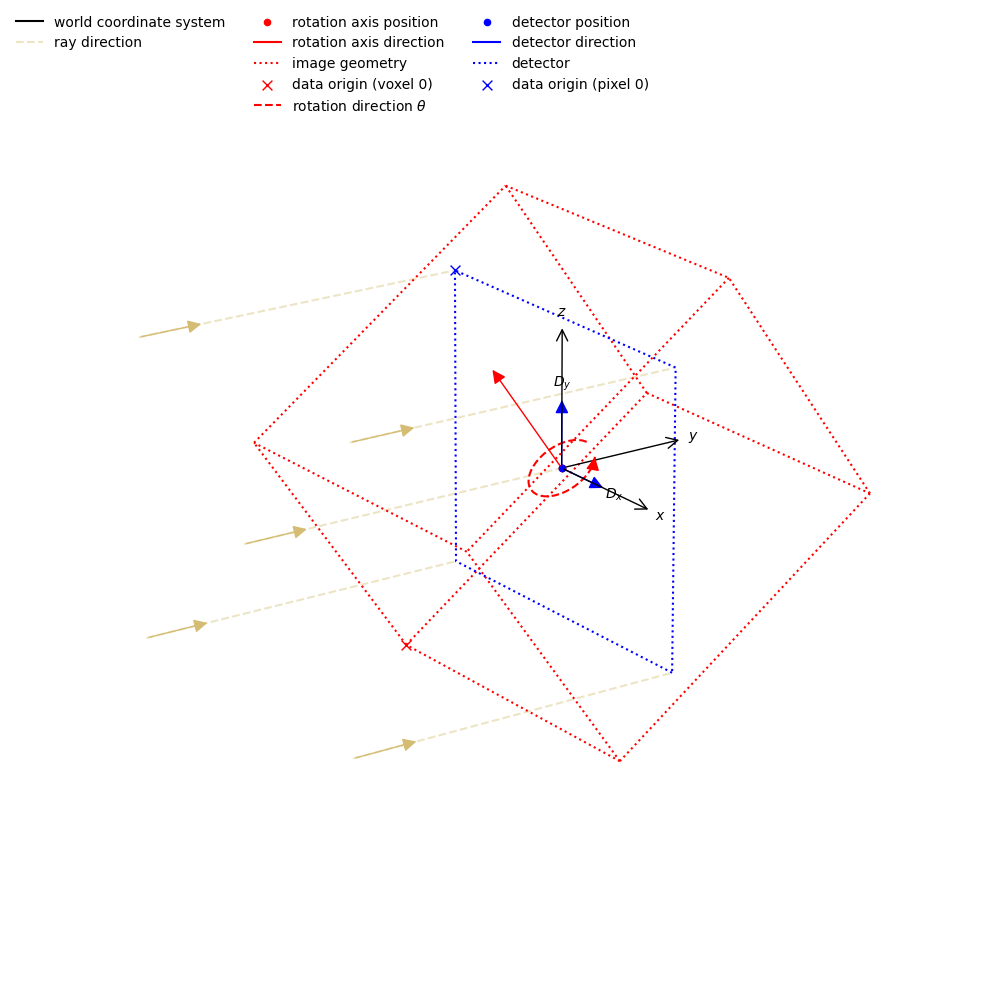

In [4]:
tilt_direction_vector=np.array([1, 0, 0])
original_rotation_axis=np.array([0, 0, 1])

rotation_matrix = R.from_rotvec(np.deg2rad(tilt) * tilt_direction_vector)
tilted_rotation_axis = rotation_matrix.apply(original_rotation_axis)

ag = AcquisitionGeometry.create_Parallel3D(rotation_axis_direction=tilted_rotation_axis)
ag.set_angles(angles[image_key==0,])
ag.set_panel([data.shape[2], data.shape[1]],
             pixel_size = (pixel_size_x, pixel_size_y),
             origin='top-left')

ag.set_centre_of_rotation(offset=cor, distance_units='pixels')


ag.config.system.rotation_axis.direction = tilted_rotation_axis

show_geometry(ag)

data = AcquisitionData(data, geometry=ag)

Next we apply a flat and dark field correction and apply the Beer-Lambert law

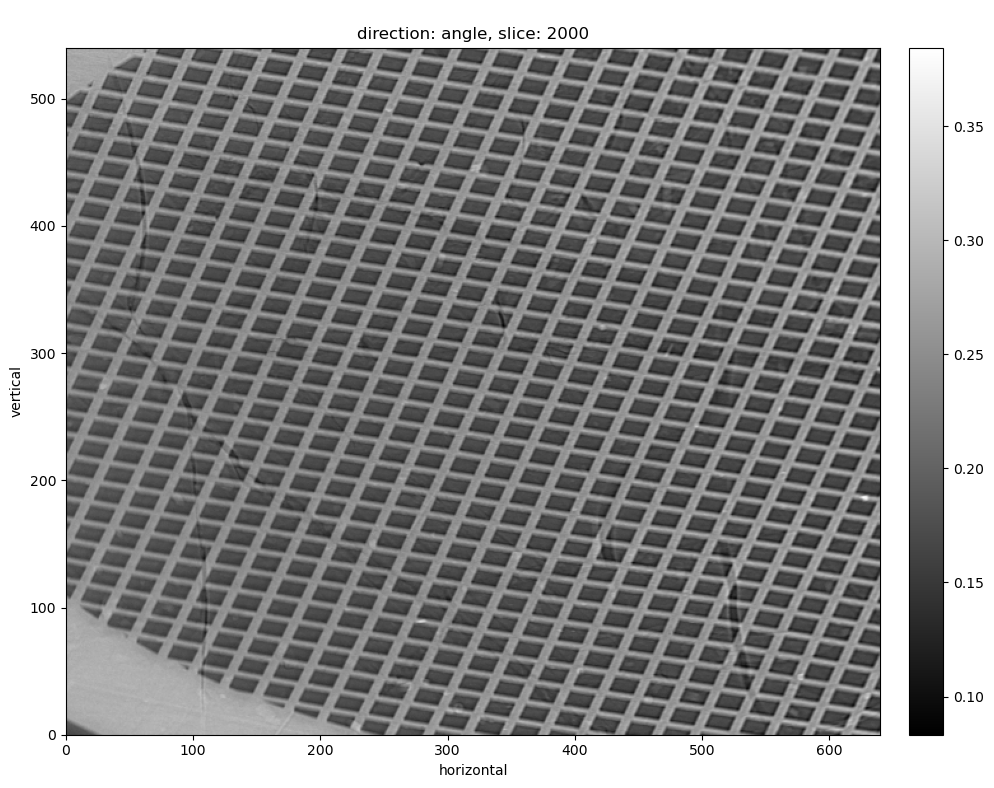

In [5]:
data = Normaliser(np.mean(flat, axis=0), np.mean(dark, axis=0))(data)
data = TransmissionAbsorptionConverter(min_intensity=1e-6)(data)
show2D(data)

We reorder the data in the order required by astra

In [6]:
data.reorder('astra')
print(data.dimension_labels)

(<AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)


Now we try reconstructing the data with our initial geometry guess

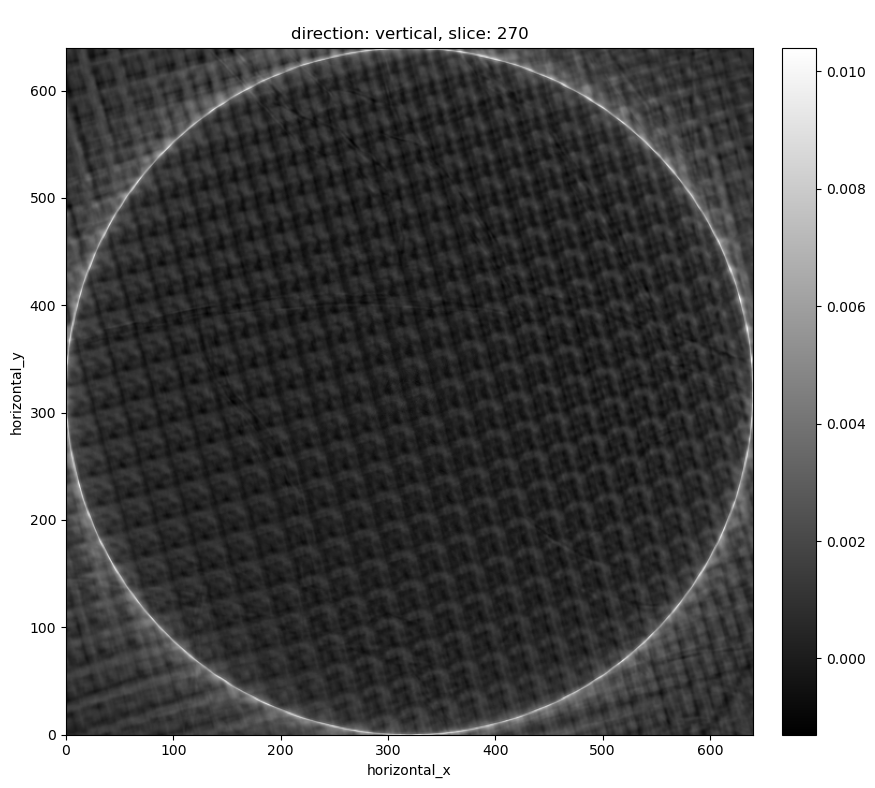

In [7]:
ag = data.geometry
ig = ag.get_ImageGeometry()

fbp = FBP(ig, ag)
recon = fbp(data)
show2D(recon)

If we want to optimise the geometry, we use the `GeometryCorrector` tool to get a more accurate estimate of the tilt and centre of rotation parameters from the data itself. This tool uses a projection matching method to guess the geometry and minimise the difference between a reprojected reconstruction and the original projections. 

This method can be slow so we first shrink the reconstruction volume as much as possible using the `VolumeShrinker` tool. Here we set the method to auto, however we can over-ride these limits with our own manual_limits, which we can adjust and check on the reconstruction volume.

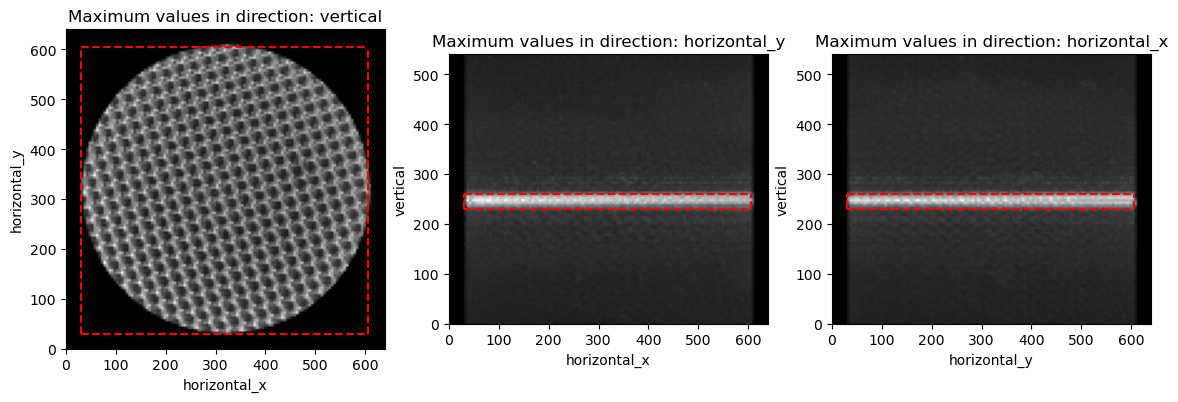

In [8]:
if optimise_geometry:
    vs = VolumeShrinker()
    ig = vs.run(data, auto=True)

`GeometryCorrector` starts with a coarse minimisation using an initial_binning in detector space, then does a fine minimisation at full resolution. The search bounds and tolerance are set at the top of the notebook

In [9]:
if optimise_geometry:

    if data.get_dimension_size('horizontal') > 1280:
        final_binning = 2
    else:
        final_binning = None
    
    processor = GeometryCorrector(initial_parameters=(tilt, cor), parameter_bounds=(tilt_bounds, cor_bounds), parameter_tolerance=(tilt_tol, cor_tol),
                                  final_binning=final_binning, reduced_volume=ig)

    processor.set_input(data)
    data_corrected = processor.get_output()

    processor.plot_evaluations()

Tilt bounds : (30.000:40.000), CoR bounds : (-20.000:20.000)
tilt: 35.000, CoR: 0.000, loss: 4.133e+05
tilt: 33.820, CoR: 0.000, loss: 4.115e+05
tilt: 36.180, CoR: 0.000, loss: 4.136e+05
tilt: 32.361, CoR: 0.000, loss: 4.148e+05
tilt: 34.454, CoR: 0.000, loss: 4.127e+05
tilt: 33.262, CoR: 0.000, loss: 4.113e+05
tilt: 33.410, CoR: 0.000, loss: 4.112e+05
tilt: 33.476, CoR: 0.000, loss: 4.112e+05
tilt: 33.461, CoR: 0.000, loss: 4.112e+05
tilt: 33.458, CoR: 0.000, loss: 4.112e+05
tilt: 33.465, CoR: 0.000, loss: 4.112e+05
tilt: 33.461, CoR: -4.721, loss: 4.184e+05
tilt: 33.461, CoR: 4.721, loss: 3.929e+05
tilt: 33.461, CoR: 10.557, loss: 3.976e+05
tilt: 33.461, CoR: 5.869, loss: 3.958e+05
tilt: 33.461, CoR: 1.115, loss: 4.065e+05
tilt: 33.461, CoR: 3.344, loss: 3.943e+05
tilt: 33.461, CoR: 4.388, loss: 3.926e+05
tilt: 33.461, CoR: 4.324, loss: 3.926e+05
tilt: 33.461, CoR: 4.294, loss: 3.926e+05
tilt: 33.461, CoR: 4.304, loss: 3.926e+05
tilt: 33.461, CoR: 3.931, loss: 3.928e+05
tilt: 33.461,

KeyboardInterrupt: 

Finally we do a full resolution reconstruction using the minimised parameters and look at some vertical slices throughout the volume

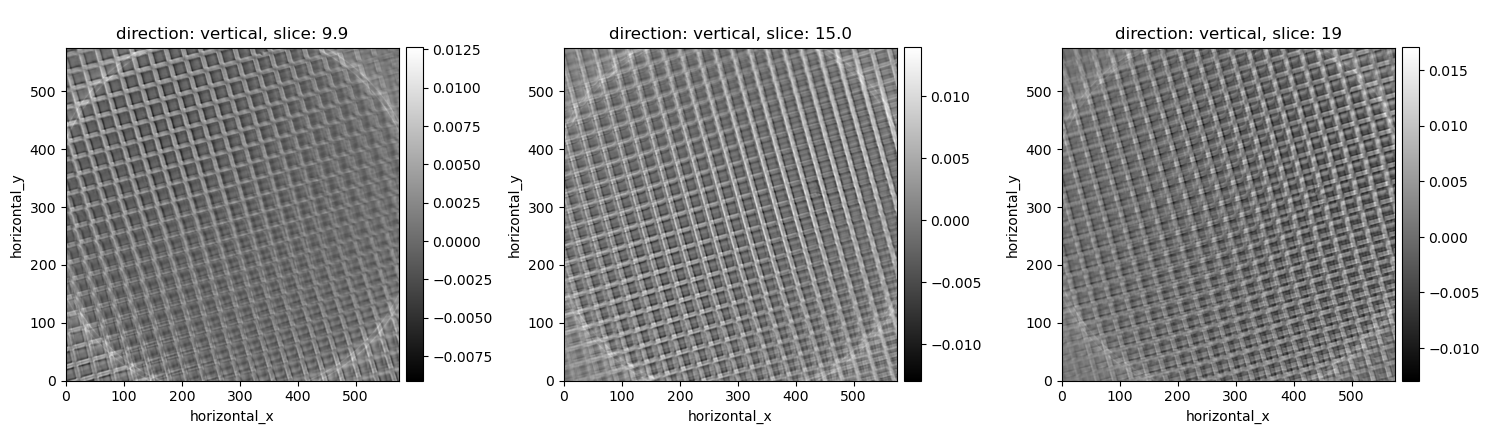

In [50]:
if optimise_geometry:
    recon = FBP(ig, data_corrected.geometry)(data_corrected)
    slice_list = [('vertical',  int(ig.voxel_num_z)*0.33), ('vertical', int(ig.voxel_num_z)*0.5), ('vertical', int(ig.voxel_num_z*0.66))]
    show2D(recon, slice_list=slice_list, num_cols=3)

Save the reconstruction as tiff files

In [47]:
from pathlib import Path
fp = Path(file_path)
recon_dir = fp.with_name(fp.stem + '_recon')
recon_dir.mkdir(parents=True, exist_ok=True)

TIFFWriter(recon, os.path.join(recon_dir, fp.stem + '_recon')).write()